In [1]:
!pip install pyspark
!pip install findspark

In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import *

24/03/31 00:02:39 WARN Utils: Your hostname, Manans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.29.201 instead (on interface en0)
24/03/31 00:02:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/31 00:02:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/31 00:02:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/03/31 00:02:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
import os
from pyspark.sql import SparkSession

# Set SPARK_LOCAL_IP to desired IP address
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# Suppress Spark logging warnings
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.ui.port=4041 pyspark-shell"

# Initialize Spark session
spark = SparkSession.builder \
    .appName("YourAppName") \
    .getOrCreate()

24/03/31 00:05:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# Paths for data.
Ravdess = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/RAVDESS/audio_speech_actors_01-24/"
Tess = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/"
Savee = "/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/SAVEE/"

In [7]:
def visualize_audio(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path)
    
    # Create waveform plot
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Create spectrogram plot
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()


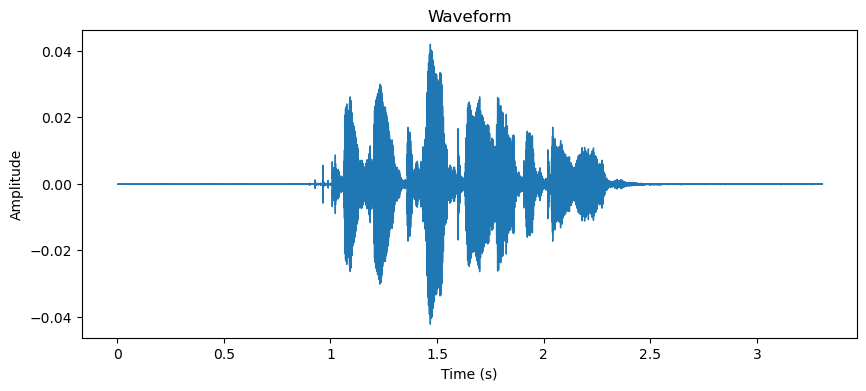

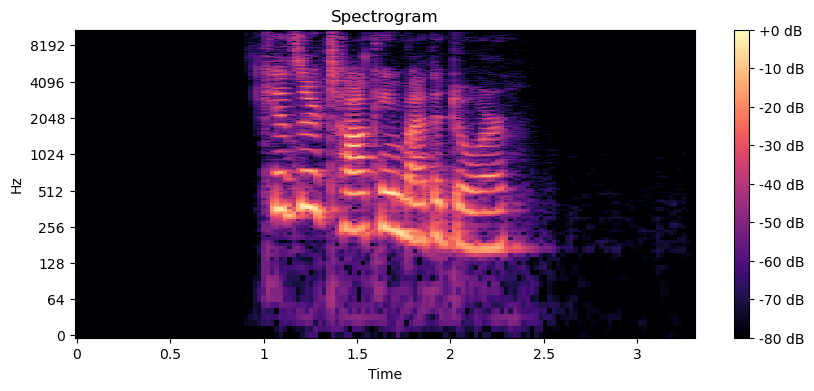

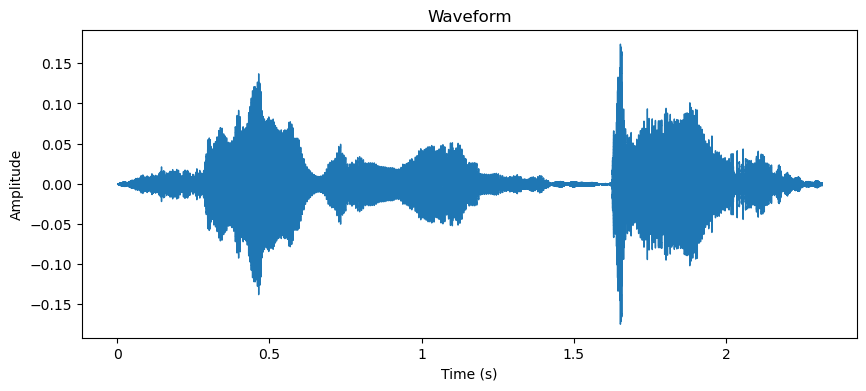

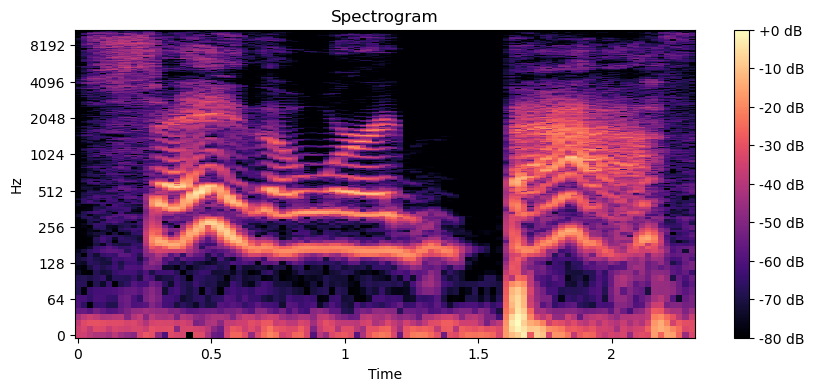

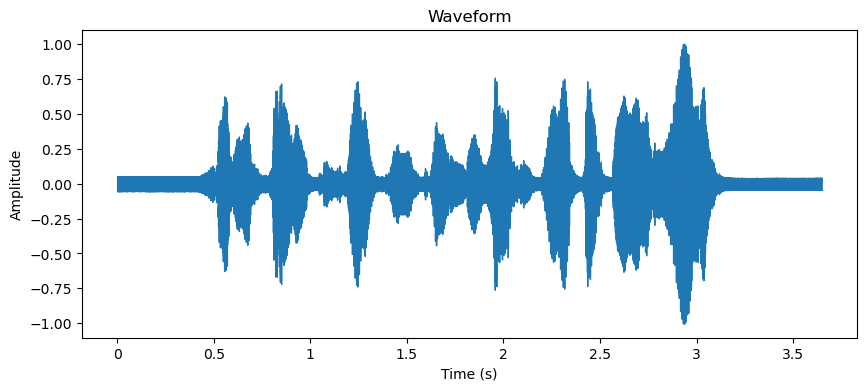

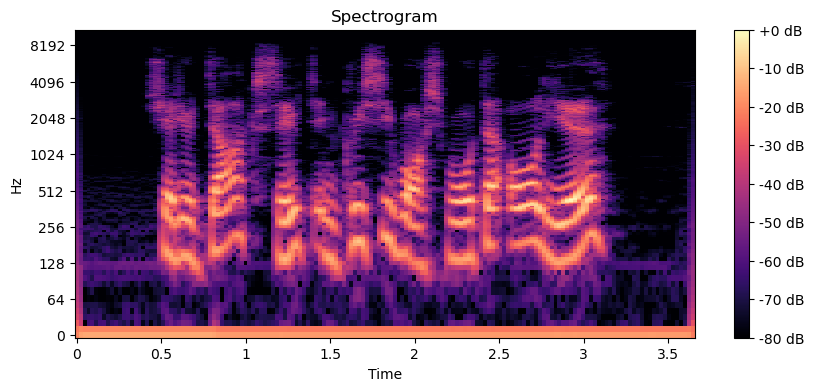

In [8]:
ravdess_audio_path = Ravdess + "/Actor_04/03-01-01-01-01-01-04.wav"
visualize_audio(ravdess_audio_path)

# Visualize audio from Tess dataset
tess_audio_path = Tess + "/TESS Toronto emotional speech set data/OAF_disgust/OAF_bath_disgust.wav"
visualize_audio(tess_audio_path)

# Visualize audio from Savee dataset
savee_audio_path = Savee + "/DC_a01.wav"
visualize_audio(savee_audio_path)

In [17]:
audio_files_df = spark.read.format("binaryFile").load("/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/RAVDESS/audio_speech_actors_01-24//Actor_04/03-01-01-01-01-01-04.wav")

# Define a function to extract audio features
def extract_features(file_content):
    # Convert binary audio data to numpy array
    audio_data = np.frombuffer(file_content, dtype=np.int16)
    # Convert audio data to floating-point format
    audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max
    # Extract features using librosa or any other library
    features = librosa.feature.mfcc(y=audio_data, sr=16000)  # Example: MFCC features
    return features.tolist()

# Register the function as a UDF (User Defined Function)
extract_features_udf = udf(extract_features, ArrayType(FloatType()))

# Apply the UDF to extract features from audio files
processed_audio_df = audio_files_df.withColumn("features", extract_features_udf(audio_files_df["content"]))

# Show the processed DataFrame
processed_audio_df.show()

+--------------------+-------------------+------+--------------------+--------------------+
|                path|   modificationTime|length|             content|            features|
+--------------------+-------------------+------+--------------------+--------------------+
|file:/Users/manan...|2019-10-17 22:32:30|374522|[52 49 46 46 F2 B...|[NULL, NULL, NULL...|
+--------------------+-------------------+------+--------------------+--------------------+



In [26]:
import io

def extract_mel_spectrogram(file_content):
    # Convert binary audio data to numpy array
    audio_data, _ = librosa.load(io.BytesIO(file_content), sr=22050)  # Sample rate 22.05 kHz
    # Extract Mel Spectrogram features
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=22050)
    return mel_spectrogram.tolist()

# Register the function as a UDF
extract_mel_spectrogram_udf = udf(extract_mel_spectrogram, ArrayType(ArrayType(FloatType())))

# Apply the UDF to extract Mel Spectrogram features from audio files
processed_audio_df = audio_files_df.withColumn("mel_spectrogram", extract_mel_spectrogram_udf(audio_files_df["content"]))

# Define UDFs for computing statistics
mean_udf = udf(lambda x: float(np.mean(x)), FloatType())
stddev_udf = udf(lambda x: float(np.std(x)), FloatType())
min_udf = udf(lambda x: float(np.min(x)), FloatType())
max_udf = udf(lambda x: float(np.max(x)), FloatType())

# Compute statistics for Mel Spectrogram features
processed_audio_df = processed_audio_df.withColumn("mel_spectrogram_mean", mean_udf(processed_audio_df["mel_spectrogram"]))
processed_audio_df = processed_audio_df.withColumn("mel_spectrogram_stddev", stddev_udf(processed_audio_df["mel_spectrogram"]))
processed_audio_df = processed_audio_df.withColumn("mel_spectrogram_min", min_udf(processed_audio_df["mel_spectrogram"]))
processed_audio_df = processed_audio_df.withColumn("mel_spectrogram_max", max_udf(processed_audio_df["mel_spectrogram"]))

# Show the processed DataFrame
processed_audio_df.show()

+--------------------+-------------------+------+--------------------+--------------------+--------------------+----------------------+-------------------+-------------------+
|                path|   modificationTime|length|             content|     mel_spectrogram|mel_spectrogram_mean|mel_spectrogram_stddev|mel_spectrogram_min|mel_spectrogram_max|
+--------------------+-------------------+------+--------------------+--------------------+--------------------+----------------------+-------------------+-------------------+
|file:/Users/manan...|2019-10-17 22:32:30|374522|[52 49 46 46 F2 B...|[[0.0, 0.0, 0.0, ...|         0.003945905|            0.04919575|                0.0|           2.145523|
+--------------------+-------------------+------+--------------------+--------------------+--------------------+----------------------+-------------------+-------------------+



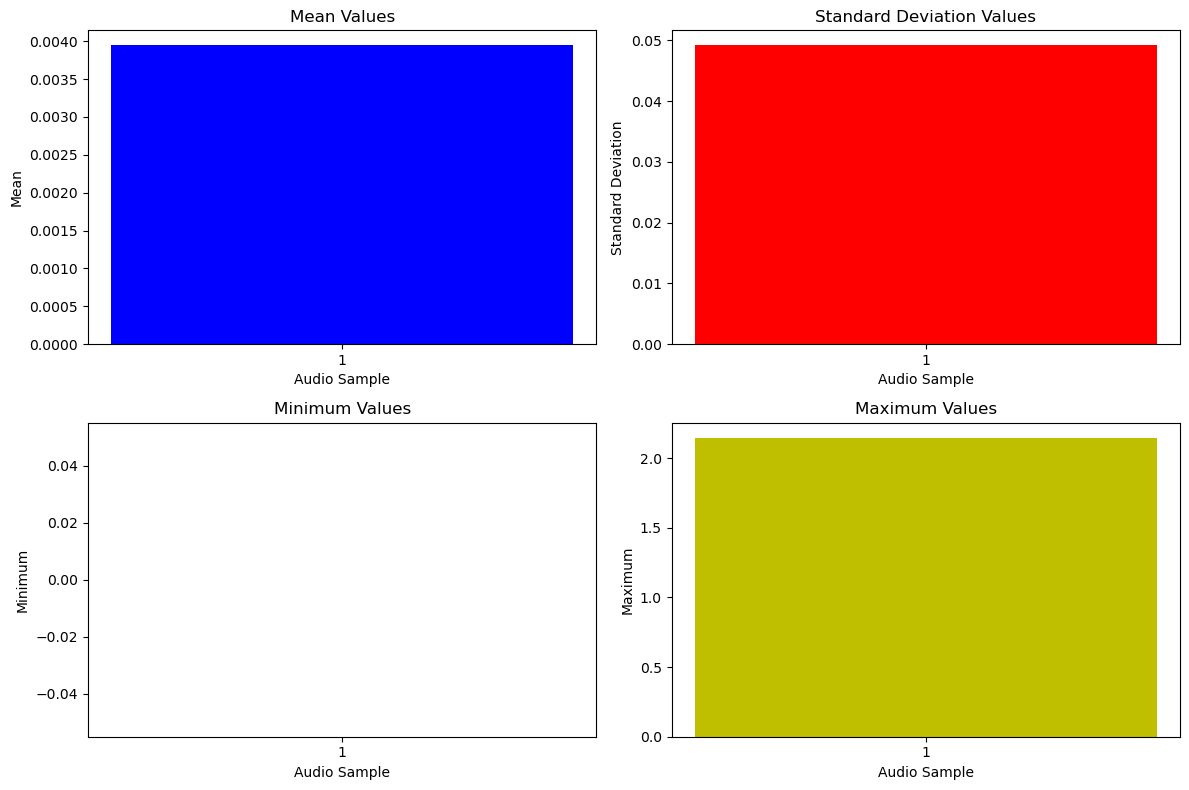

In [28]:
import matplotlib.pyplot as plt

# Extract statistics from the DataFrame
mean_values = processed_audio_df.select("mel_spectrogram_mean").collect()
stddev_values = processed_audio_df.select("mel_spectrogram_stddev").collect()
min_values = processed_audio_df.select("mel_spectrogram_min").collect()
max_values = processed_audio_df.select("mel_spectrogram_max").collect()

# Convert statistics to lists
mean_values = [row["mel_spectrogram_mean"] for row in mean_values]
stddev_values = [row["mel_spectrogram_stddev"] for row in stddev_values]
min_values = [row["mel_spectrogram_min"] for row in min_values]
max_values = [row["mel_spectrogram_max"] for row in max_values]

# Audio sample indices
indices = range(1, len(mean_values) + 1)

# Plotting the statistics
plt.figure(figsize=(12, 8))

# Plot mean values
plt.subplot(2, 2, 1)
plt.bar(indices, mean_values, color='b')
plt.title('Mean Values')
plt.xlabel('Audio Sample')
plt.ylabel('Mean')
plt.xticks(indices)

# Plot standard deviation values
plt.subplot(2, 2, 2)
plt.bar(indices, stddev_values, color='r')
plt.title('Standard Deviation Values')
plt.xlabel('Audio Sample')
plt.ylabel('Standard Deviation')
plt.xticks(indices)

# Plot minimum values
plt.subplot(2, 2, 3)
plt.bar(indices, min_values, color='g')
plt.title('Minimum Values')
plt.xlabel('Audio Sample')
plt.ylabel('Minimum')
plt.xticks(indices)

# Plot maximum values
plt.subplot(2, 2, 4)
plt.bar(indices, max_values, color='y')
plt.title('Maximum Values')
plt.xlabel('Audio Sample')
plt.ylabel('Maximum')
plt.xticks(indices)

plt.tight_layout()
plt.show()


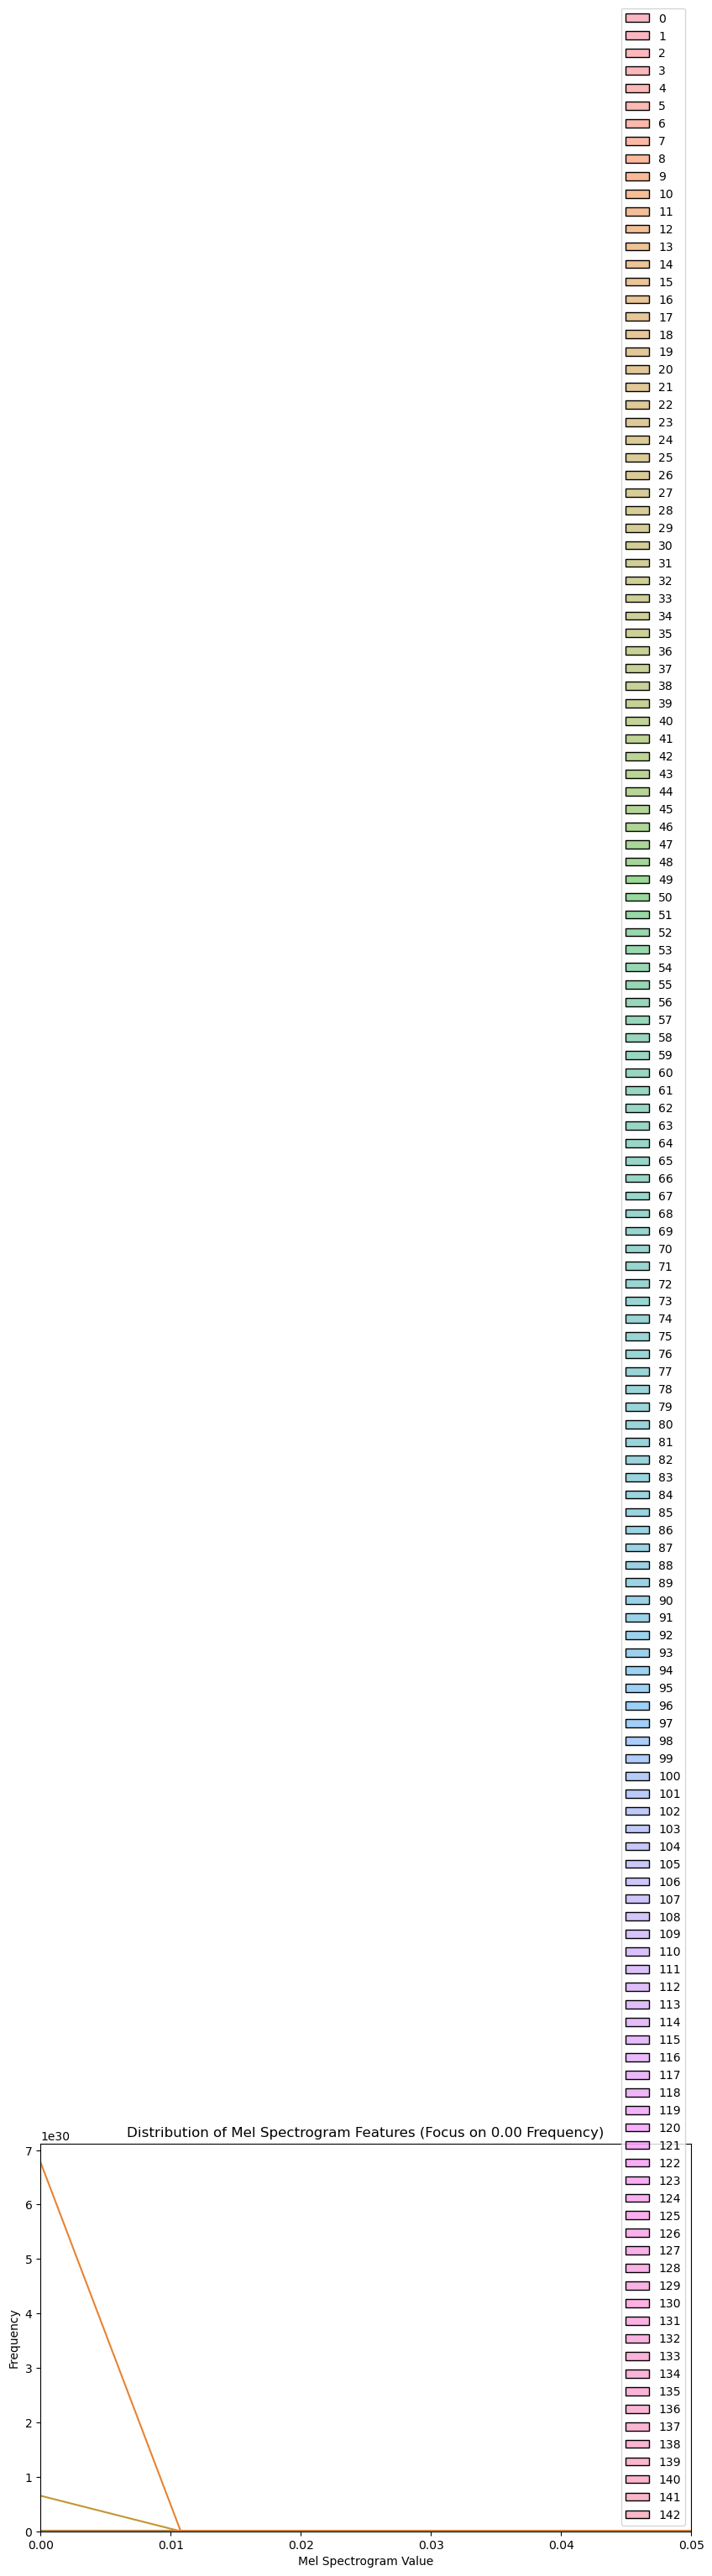

In [31]:
import numpy as np

# Flatten Mel Spectrogram data
mel_spectrogram_flat = np.concatenate([row["mel_spectrogram"] for row in mel_spectrogram_data])

# Plotting the distribution of Mel Spectrogram features
# Plotting the distribution of Mel Spectrogram features focusing on the region near 0.00 frequency
plt.figure(figsize=(10, 6))
sns.histplot(mel_spectrogram_flat, bins=20, kde=True)
plt.title('Distribution of Mel Spectrogram Features (Focus on 0.00 Frequency)')
plt.xlabel('Mel Spectrogram Value')
plt.ylabel('Frequency')
plt.xlim(0, 0.05)  # Adjust the x-axis limits to focus on the region near 0.00 frequency
plt.show()



In [32]:
# Filter out .DS_Store file from the list
ravdess_directory_list = [d for d in os.listdir(Ravdess) if not d.startswith('.DS_Store')]

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Change integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

Ravdess_df.head()

,Emotions,Path
0,angry,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,fear,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,fear,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,angry,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [33]:

tess_directory_list = [d for d in os.listdir(Tess) if not d.startswith('.DS_Store')]

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0]
        split_part = part.split('_')
        
        # Check if split_part has at least three elements
        if len(split_part) >= 3:
            part = split_part[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(os.path.join(Tess, dir, file))
        else:
            # Handle the case where split_part does not have enough elements
            print(f"Skipping file: {file} in directory {dir} as it does not have enough parts.")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()

Skipping file: YAF_disgust in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_happy in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_sad in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_happy in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_neutral in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_Fear in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_angry in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: YAF_fear in directory TESS Toronto emotional speech set data as it does not have enough parts.
Skipping file: OAF_neutral in directory TESS Toronto emotional speech set data as it does not have enough parts.

,Emotions,Path
0,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,disgust,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [34]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

,Emotions,Path
0,sad,/Users/mananhingorani/Speech-Emotion-Recogniti...
1,sad,/Users/mananhingorani/Speech-Emotion-Recogniti...
2,neutral,/Users/mananhingorani/Speech-Emotion-Recogniti...
3,surprise,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,neutral,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [36]:
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)

# Shuffle the dataframe using the sample method
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True) 

# Drop rows where Emotions is 'fear' or 'disgust'
aggregated_data = aggregated_data[~aggregated_data['Emotions'].isin(['fear', 'disgust'])]

# Drop rows where Emotions is "sad" and "angry" and replace them with "unpleasant"
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'sad'].sample(frac=0.4).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'angry'].sample(frac=0.4).index)
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['sad', 'angry'], 'unpleasant')

aggregated_data.to_csv("data_path.csv",index=False)
aggregated_data.head()

,Emotions,Path
3,surprise,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,unpleasant,/Users/mananhingorani/Speech-Emotion-Recogniti...
5,happy,/Users/mananhingorani/Speech-Emotion-Recogniti...
6,happy,/Users/mananhingorani/Speech-Emotion-Recogniti...
7,unpleasant,/Users/mananhingorani/Speech-Emotion-Recogniti...


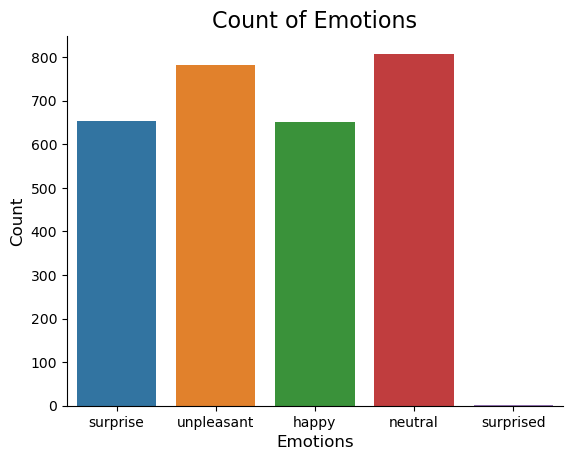

In [37]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=aggregated_data, x='Emotions')  # Specify x as 'Emotions'
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [38]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [39]:
def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [40]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(emotion), size=15)
    time = np.arange(0, len(data)) / sr
    plt.plot(time, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Rest of your code remains unchanged


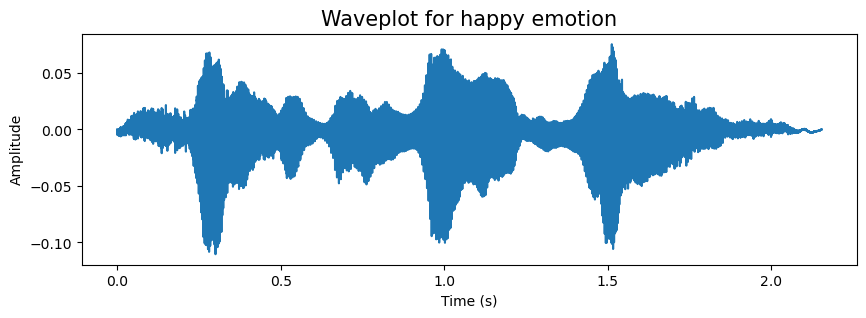

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got ndarray.

In [41]:
emotion='happy'
path = np.array(aggregated_data.Path[aggregated_data.Emotions==emotion])[1]
data, sample_rate = librosa.load(path, sr=None)  # Set sr=None to get the native sample rate
resampled_data = librosa.resample(data, orig_sr=sample_rate, target_sr=16000)
noised_data = noise(resampled_data)

create_waveplot(resampled_data, 16000, emotion)
create_spectrogram(resampled_data, 16000, emotion)
Audio(data=noised_data, rate=16000)


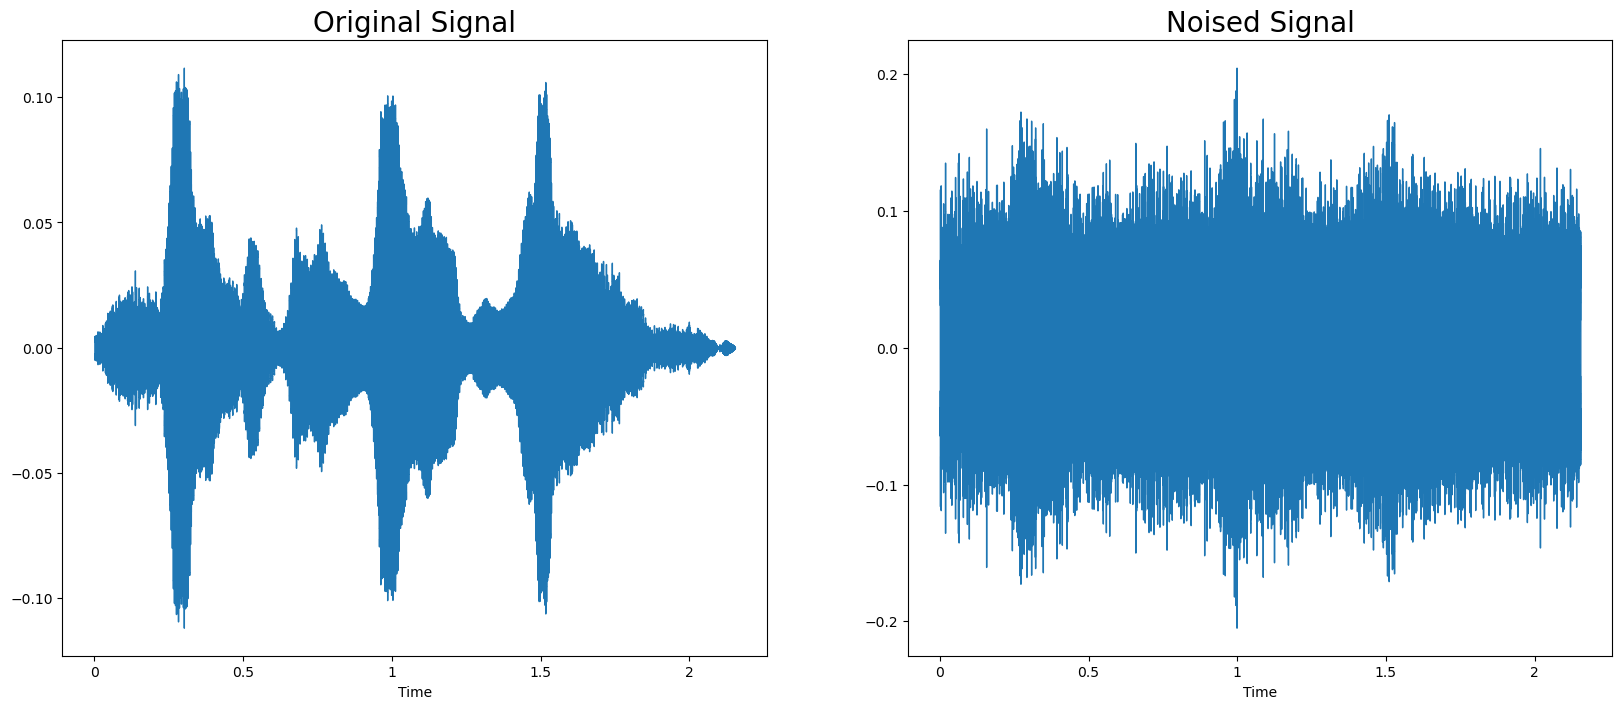

In [42]:
import matplotlib.pyplot as plt
import librosa.display

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4)

axs[0].set_title('Original Signal', size=20)
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0])

axs[1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[1])

plt.show()


In [43]:
labels = {'neutral':0, 'happy':1, 'surprise':2, 'unpleasant': 3}
aggregated_data.replace({'Emotions':labels},inplace=True)
aggregated_data.head()

,Emotions,Path
3,2,/Users/mananhingorani/Speech-Emotion-Recogniti...
4,3,/Users/mananhingorani/Speech-Emotion-Recogniti...
5,1,/Users/mananhingorani/Speech-Emotion-Recogniti...
6,1,/Users/mananhingorani/Speech-Emotion-Recogniti...
7,3,/Users/mananhingorani/Speech-Emotion-Recogniti...


In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
# Constants
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = aggregated_data.shape[0]

data = {
    "labels": [],
    "features": []
}

MAX_SEQUENCE_LENGTH = 100 

def extract_features(signal, sample_rate):
    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=N_FFT, hop_length=HOP_LENGTH)

    # Extract MFCC features from the spectrogram
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(spectrogram), n_mfcc=NUM_MFCC)

    # Transpose the feature matrix
    feature = mfcc.T

    return feature

for i in range(SAMPLE_NUM):
    # Inside your loop
    file_path = aggregated_data.iloc[i, 1]

    if os.path.isfile(file_path):
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # Cropping & Resampling
        start_time = 0.4
        end_time = 1.9
        start_frame = int(start_time * sample_rate)
        end_frame = int(end_time * sample_rate)
        signal = signal[start_frame:end_frame]

        # Resample
        signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)

        # Add noise
        signal_noised = noise(signal)

        # Extract features for original signal
        features_original = extract_features(signal, DOWN_SAMPLE_RATE)
        data["labels"].append(aggregated_data.iloc[i, 0])
        data["features"].append(features_original)

        # Extract features for noised signal
        features_noised = extract_features(signal_noised, DOWN_SAMPLE_RATE)
        data["labels"].append(aggregated_data.iloc[i, 0])
        data["features"].append(features_noised)

        if i % 100 == 0:
            print(f'Processing Data: {i}/{SAMPLE_NUM}')
    else:
        print(f'Skipping directory: {file_path}')

# Convert lists to numpy arrays
data["features"] = pad_sequences(data["features"], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', dtype='float32')
data["labels"] = np.array(data["labels"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["labels"], test_size=0.2, random_state=42)


Processing Data: 0/2896
Processing Data: 100/2896
Processing Data: 200/2896
Processing Data: 300/2896
Processing Data: 400/2896
Processing Data: 500/2896
Processing Data: 600/2896
Processing Data: 700/2896
Processing Data: 800/2896
Processing Data: 900/2896
Processing Data: 1000/2896
Processing Data: 1100/2896
Processing Data: 1200/2896
Processing Data: 1300/2896
Processing Data: 1400/2896
Skipping directory: /Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised
Processing Data: 1500/2896
Processing Data: 1600/2896
Processing Data: 1700/2896
Processing Data: 1800/2896
Processing Data: 1900/2896
Processing Data: 2000/2896
Processing Data: 2100/2896
Processing Data: 2200/2896
Processing Data: 2300/2896
Processing Data: 2400/2896
Skipping directory: /Users/mananhingorani/Speech-Emotion-Recognition-TinyML/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set d

In [46]:
data["features"] = [feature.flatten() for feature in data["features"]]

# Create a DataFrame
Features = pd.DataFrame(data)

# Save the DataFrame to a CSV file
Features.to_csv('Features.csv', index=False)

# Display the first few rows of the DataFrame
Features.head()

,labels,features
0,2,"[-281.50693, 97.52937, -13.855398, -6.4087496,..."
1,2,"[-137.9801, 12.141749, 10.779172, -9.984026, -..."
2,3,"[-165.39809, 47.62387, -13.098591, 60.35501, -..."
3,3,"[-4.360909, -5.140632, 2.9106617, 2.4838207, -..."
4,1,"[-159.70421, 7.443445, -2.8773198, 61.862206, ..."


In [47]:
X = np.asarray(Features['features'])
y = np.asarray(Features["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f' Testing Data:{X_test.shape} with label {y_test.shape}')

Training Data:(4167, 1300) with label (4167,)
Validate Data:(1042, 1300) with label (1042,)
 Testing Data:(579, 1300) with label (579,)


In [49]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [50]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

# Adjusted for sequences of length 100
input_shape = (MAX_SEQUENCE_LENGTH, NUM_MFCC)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 126532 (494.27 KB)
Trainable params: 126532 (494.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
X_train = X_train.reshape((X_train.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))
X_validation = X_validation.reshape((X_validation.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))
X_test = X_test.reshape((X_test.shape[0], MAX_SEQUENCE_LENGTH, NUM_MFCC))


In [52]:
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=EPOCHS)

Epoch 1/20
131/131 [==============================] - 12s 77ms/step - loss: 1.2489 - accuracy: 0.3849 - val_loss: 1.1172 - val_accuracy: 0.4405
Epoch 2/20
131/131 [==============================] - 9s 72ms/step - loss: 1.0600 - accuracy: 0.5056 - val_loss: 0.9809 - val_accuracy: 0.5432
Epoch 3/20
131/131 [==============================] - 10s 77ms/step - loss: 0.9799 - accuracy: 0.5445 - val_loss: 0.9593 - val_accuracy: 0.5624
Epoch 4/20
131/131 [==============================] - 10s 73ms/step - loss: 0.9252 - accuracy: 0.5824 - val_loss: 0.9216 - val_accuracy: 0.5528
Epoch 5/20
131/131 [==============================] - 9s 72ms/step - loss: 0.8911 - accuracy: 0.6060 - val_loss: 0.7590 - val_accuracy: 0.6747
Epoch 6/20
131/131 [==============================] - 9s 72ms/step - loss: 0.8106 - accuracy: 0.6506 - val_loss: 0.7828 - val_accuracy: 0.6536
Epoch 7/20
131/131 [==============================] - 10s 73ms/step - loss: 0.7756 - accuracy: 0.6707 - val_loss: 0.7480 - val_accuracy: 0.

In [53]:
# Create a new directory called 'Models' to store the model
output_dir = 'Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model in the 'Models' directory
model.save('Models/Speech-Emotion-Recognition-Model-new.h5')
print('Save the Tensorflow model!')


Save the Tensorflow model!


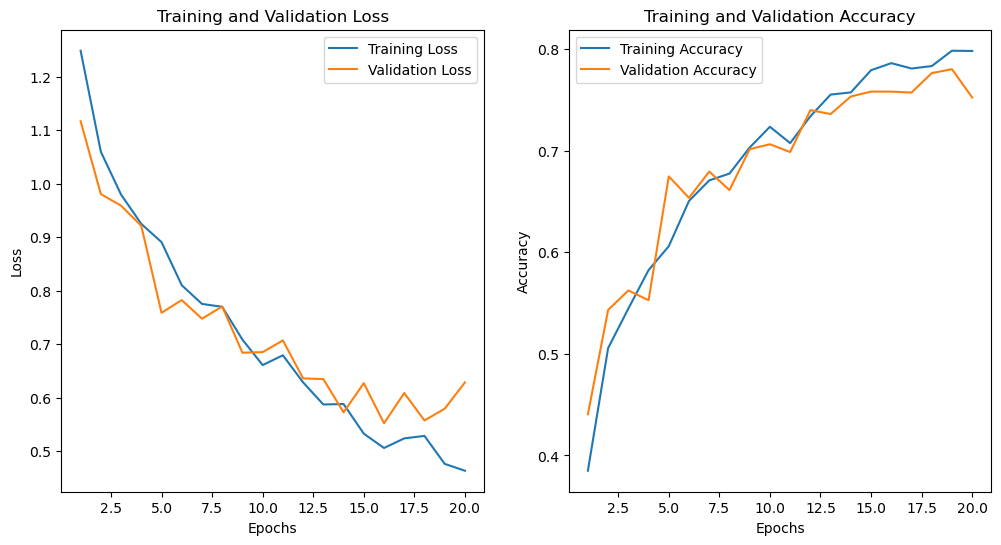

In [54]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_loss, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_acc, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


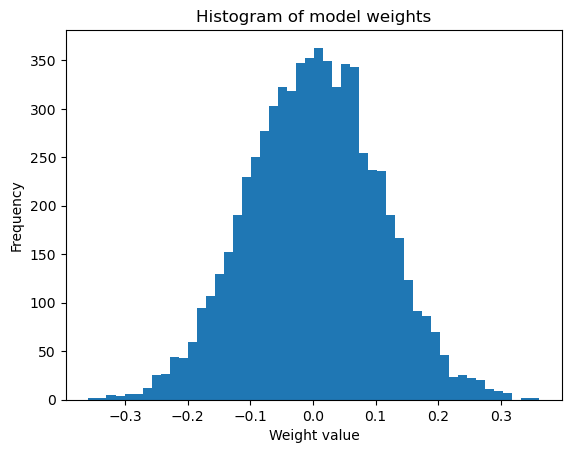

In [55]:
weights = model.get_weights()

# Plot a histogram of the weights
plt.hist(weights[0].flatten(), bins=50)
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.title('Histogram of model weights')
plt.show()

In [56]:
# Convert to TensorFlow Lite model with TF kernels fallback
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with tf.io.gfile.GFile("Models/SER.tflite", 'wb') as f:
    f.write(tflite_model)

# Apply optimizations and convert to quantized TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with tf.io.gfile.GFile("Models/SER_quant.tflite", 'wb') as f:
    f.write(quant_tflite_model)

print("Save the TensorFlow 'Lite' model!")

INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmp1p5rcbf8/assets


INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmp1p5rcbf8/assets
2024-03-31 00:32:06.883214: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-31 00:32:06.883346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-31 00:32:06.883977: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmp1p5rcbf8
2024-03-31 00:32:06.891251: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-31 00:32:06.891264: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmp1p5rcbf8
2024-03-31 00:32:06.909590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-31 00:32:06.913188: I tensorflow/cc/saved_model/load

INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpebtwdq2h/assets


INFO:tensorflow:Assets written to: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpebtwdq2h/assets


Save the TensorFlow 'Lite' model!


2024-03-31 00:32:10.620326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-31 00:32:10.620345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-31 00:32:10.620530: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpebtwdq2h
2024-03-31 00:32:10.627126: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-31 00:32:10.627141: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpebtwdq2h
2024-03-31 00:32:10.645059: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-31 00:32:10.711817: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/22/yhwhv5gd6f3bfwm46s4bztfw0000gn/T/tmpebtwdq2h
2024-03-

In [57]:
print("Model Sizes:")
!ls -lh Models | awk '{print $5 "\t" $9}'

Model Sizes:
	
514K	SER.tflite
904K	SER_micro.cc
147K	SER_quant.tflite
1.5M	Speech-Emotion-Recognition-Model-new.h5
1.5M	Speech-Emotion-Recognition-Model.h5


In [58]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import librosa
import numpy as np

# Load the saved model
saved_model_path = '/Users/mananhingorani/Speech-Emotion-Recognition-TinyML/Models/Speech-Emotion-Recognition-Model-new.h5'
loaded_model = load_model(saved_model_path)

In [59]:
# Function to extract features from sound data
def extract_features(file_path, max_sequence_length=100):
    # Load sound file using librosa
    signal, sample_rate = librosa.load(file_path, sr=None)

    # Cropping & Resampling (similar to what you did during training)
    start_time = 0.4
    end_time = 1.9
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]

    # Resample
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=16000)

    # Extract features for the sound data
    spectrogram = librosa.feature.melspectrogram(y=signal, sr=16000, n_fft=2048, hop_length=512)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(spectrogram), n_mfcc=13)

    # Transpose features to have shape (num_features, sequence_length)
    features = mfcc.T

    # Pad or truncate features to a fixed length
    features = np.pad(features, ((0, max_sequence_length - features.shape[0]), (0, 0)), mode='constant')

    return features


In [60]:
def predict_emotion(sound_file_path):
    # Extract features
    sound_features = extract_features(sound_file_path)

    # Ensure sound_features has the correct shape (adjust if necessary)
    sound_features = np.expand_dims(sound_features, axis=0)

    # Make predictions using the loaded model
    emotion_probabilities = loaded_model.predict(sound_features)

    # Convert the probabilities to emotion labels
    predicted_emotion = np.argmax(emotion_probabilities, axis=1)

    # Map the predicted label to the actual emotion class (e.g., using a dictionary)
    emotion_mapping = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'unpleasant'}
    predicted_emotion_label = emotion_mapping[predicted_emotion[0]]

    return predicted_emotion_label

In [61]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 4.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 379ms/step
Predicted Emotion: surprise


In [62]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 5.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 47ms/step
Predicted Emotion: surprise


In [63]:
sound_file_path = '/Users/mananhingorani/Downloads/Business Badhao 9.m4a'
predicted_emotion = predict_emotion(sound_file_path)

# Print or use the predicted emotion label
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 47ms/step
Predicted Emotion: happy
